In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark import StorageLevel
from geopyspark.geopycontext import GeoPyContext
from geopyspark.geotrellis import Extent
from geopyspark.geotrellis.constants import SPATIAL, NODATAINT, MAX, SQUARE, EXACT, ZOOM
from geopyspark.geotrellis.rdd import TiledRasterRDD
from geopyspark.geotrellis.pyramid import Pyramid
from geopyspark.geotrellis.constants import *
import json
import shapely
from shapely.geometry import shape, asShape, MultiPoint, MultiLineString
import matplotlib.pyplot as plt

from geonotebook.wrappers import RddRasterData

%matplotlib inline

conf = SparkConf()
conf.setMaster("local[*]")

gps = GeoPyContext(SparkContext.getOrCreate(conf))

In [2]:
with open('roads.geojson', encoding='utf-8') as data_file:
    roads = json.load(data_file)
    libya_roads = MultiLineString([shape(geom['geometry']) for geom in roads['features']])

with open('Libya_shape.geojson', encoding='utf-8') as data_file:
    libya_border = shape(json.load(data_file)['features'][0]['geometry'])

In [3]:
libya_border.bounds
from geopyspark import geotrellis
Extent(*libya_border.bounds)
Extent(*libya_roads.bounds)

Extent(xmin=640503.71, ymin=2086100.24, xmax=3047702.11, ymax=3998370.3)

In [4]:
# Why does this call take any time at all?
from geopyspark.geotrellis.rdd import rasterize
from geopyspark.geotrellis import RasterizerOptions
ro = RasterizerOptions(includePartial=True, sampleType='PixelIsArea')
road_raster = rasterize(gps, geoms=libya_roads.geoms, 
                        crs="EPSG:3857", zoom=8, 
                        fill_value=1, cell_type="float32", 
                        options = ro,
                        numPartitions=20)

road_raster.layer_metadata.bounds
# TODO: numPartitions is to wee small here

Bounds(minKey=SpatialKey(col=132, row=102), maxKey=SpatialKey(col=147, row=114))

In [5]:
road_raster.srdd.rdd().getNumPartitions()

20

In [6]:
road_pp = Pyramid(road_raster.pyramid(start_zoom=8, end_zoom=1))
road_png_pp = road_pp.to_png_pyramid(color_ramp='Viridis')
#road_png_pp.persist(StorageLevel.MEMORY_AND_DISK)
M.add_layer(RddRasterData(road_png_pp, name='Roads'))

::1 - - [2017-06-20 16:34:09] "GET /handshake HTTP/1.1" 200 174 0.000757


In [7]:
road_png_pp.unpersist()
M.remove_layer(M.layers[0])

dict_values([JavaObject id=o49, JavaObject id=o48, JavaObject id=o47, JavaObject id=o46, JavaObject id=o45, JavaObject id=o44, JavaObject id=o43, JavaObject id=o42])


In [8]:
road_friction = (
    road_raster
    .reclassify({1:1}, data_type=int, replace_nodata_with=10)
)

In [ ]:
from geopyspark.geotrellis.render import PngRDD
png = PngRDD.makePyramid(road_friction, 'viridis', end_zoom=1)
png.cache()
from geonotebook.wrappers import RddRasterData
M.add_layer(RddRasterData(png, name='SRTM'))

In [ ]:
png.unpersist()
M.remove_layer(M.layers[0])

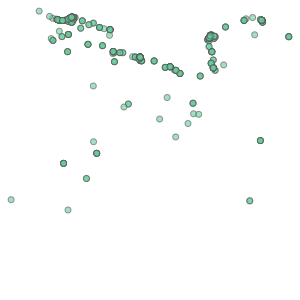

In [9]:
with open('population.geojson', encoding='utf-8') as data_file:
    population_centers = MultiPoint([shape(geom['geometry']) for geom in json.load(data_file)['features']])

with open('conflict.geojson', encoding='utf-8') as data_file:
    conflict_centers=MultiPoint([shape(feature['geometry']) for feature in json.load(data_file)['features'] if feature['geometry'] != None])
population_centers
conflict_centers

In [10]:
pop_cd = (
    road_friction
    .cost_distance(
        geometries = population_centers, 
        max_distance=1400000.0
    )
)

In [11]:
con_cd = (
    road_friction
    .cost_distance(
        geometries = conflict_centers, 
        max_distance=1400000.0
    )
)

In [12]:
from geopyspark.geotrellis.pyramid import Pyramid
from geopyspark.geotrellis.constants import *
pop_pp = Pyramid(pop_cd.pyramid(start_zoom=8, end_zoom=1))
con_pp = Pyramid(con_cd.pyramid(start_zoom=8, end_zoom=1))

In [21]:
wo = (con_pp * 0.2) + (pop_pp * -2)
png=wo.to_png_pyramid(color_ramp='Viridis')

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1035, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o307.getDoubleHistograms

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44767)
Traceback (most recent call last):
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 827, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
::1 - - [2017-06-20 16:45:20] "GET /tile/6/34/25.png HTTP/1.1" 500 663 0.019988
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:44767)
Traceback (most recent call last):
  File "/usr/local/spark-2.1.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 827, in _get_

In [ ]:
from geonotebook.wrappers import RddRasterData
M.add_layer(RddRasterData(png, name='WO'))

In [ ]:
M.remove_layer(M.layers[0])

In [ ]:
M.

In [ ]:
from geopyspark.geotrellis.render import PngRDD
png = PngRDD.makePyramid(pop_cd, 'viridis', end_zoom=1)
png.cache()
from geonotebook.wrappers import RddRasterData
M.add_layer(RddRasterData(png, name='SRTM'))